In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xesmf
from glob import glob
from utils import fix_crocotime

In [20]:
grid = xr.open_dataset('../HINDCAST/CROCO_FILES/crococeazah_grd.nc')
crocopath = glob('../HINDCAST/OUTPUT/crococeazah_avg_*.nc')
croco     = xr.open_mfdataset(crocopath, preprocess=lambda ds: ds['temp'].isel(s_rho=-1))
croco     = fix_crocotime(croco, YORIG='1950-01-01 00:00:00')
croco.coords['lon_rho'] = (croco.lon_rho+180)%360-180
sst = croco.load().where(grid.mask_rho==1)


In [21]:
grid = xr.open_dataset('../HINDCAST/CROCO_FILES/crococeazah_grd.nc')
crocopath = glob('/ceaza/lucas/storage/CROCO/OUTPUT/HINDCAST_NOTIDES/*.nc')
croco     = xr.open_mfdataset(crocopath, preprocess=lambda ds: ds['temp'].isel(s_rho=-1))
croco     = fix_crocotime(croco, YORIG='1950-01-01 00:00:00')
croco.coords['lon_rho'] = (croco.lon_rho+180)%360-180
sst2 = croco.load().where(grid.mask_rho==1)

# grid = xr.open_dataset('../HINDCAST/CROCO_FILES/crococeazah_grd.nc')
# crocopath = glob('/ceaza/lucas/storage/CROCO/OUTPUT/TIDESTEST2/*.nc')
# croco     = xr.open_mfdataset(crocopath)['temp']
# croco     = fix_crocotime(croco, YORIG='1950-01-01 00:00:00')
# croco.coords['lon_rho'] = (croco.lon_rho+180)%360-180
# sst3 = croco.isel(s_rho=-1).load().where(grid.mask_rho==1)

In [4]:
mercator = xr.open_mfdataset('~/storage/FORECAST/4DPHYSICSD/HINDCAST/2022*', preprocess=lambda ds: ds.thetao.isel(depth=0))
sstmercator = mercator.load()

In [5]:
ostia = xr.open_mfdataset('~/storage/OSTIA/2022*', preprocess=lambda ds: ds.sel(lon=slice(-75.5,-70.5), lat=slice(-33.7,-27.3)).analysed_sst).load().reindex({'time':sst.time.values}, method='nearest')-273.15

In [22]:
reference        = ostia.copy()
husk             = xr.Dataset(coords={'lat':(['lat'], reference.lat.values, reference.lat.attrs),
                                      'lon':(['lon'], reference.lon.values, reference.lon.attrs)})
regridder = xesmf.Regridder(sst.rename({'lat_rho':'lat','lon_rho':'lon'}), reference, 'bilinear')
sst       = regridder(sst)
sst2      = regridder(sst2)


regridder = xesmf.Regridder(sstmercator.rename({'latitude':'lat', 'longitude':'lon'}), reference, 'bilinear')
sstmercator = regridder(sstmercator)


ValueError: cannot rename 'latitude' because it is not a variable or dimension in this dataset

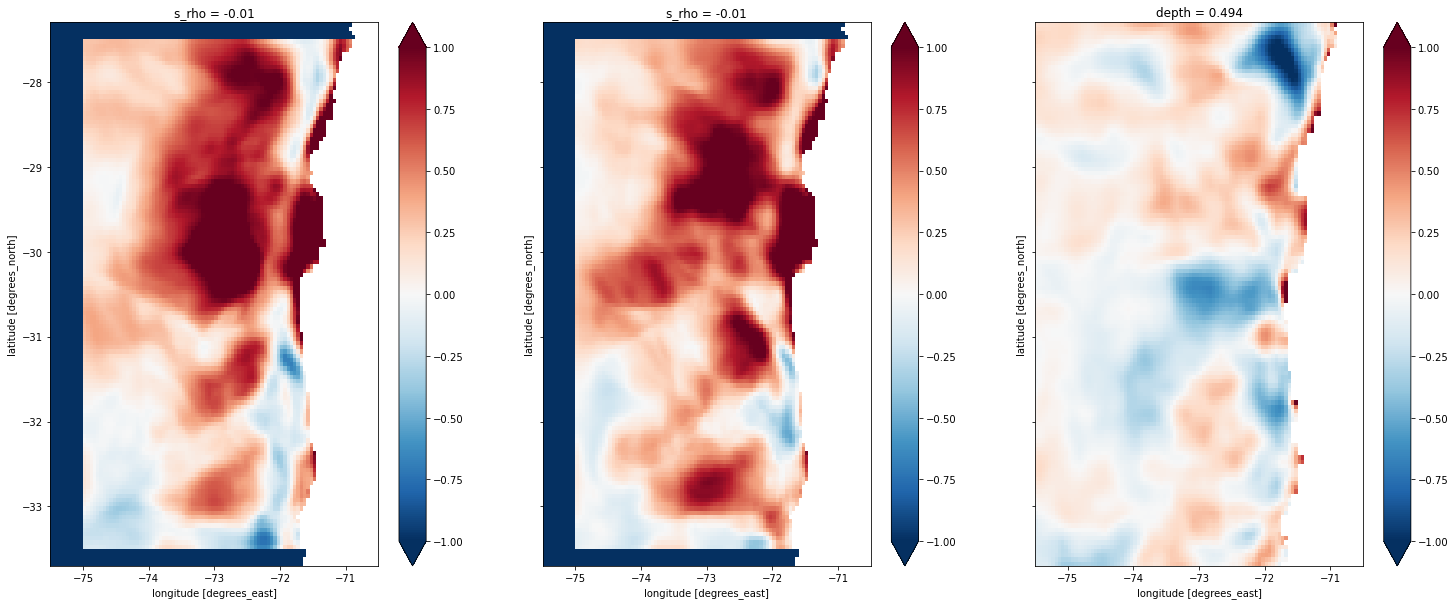

In [25]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(25,10))
(sst.temp-reference.analysed_sst).mean('time').plot(ax=ax[0], cmap='RdBu_r', vmin=-1, vmax=1)
(sst2.temp-reference.analysed_sst).mean('time').plot(ax=ax[1], cmap='RdBu_r', vmin=-1, vmax=1)
(sstmercator.resample({'time':'d'}).mean().reindex({'time':ostia.time.values}, method='nearest').thetao-reference.analysed_sst).mean('time').plot(ax=ax[2], vmin=-1, vmax=1, cmap='RdBu_r')

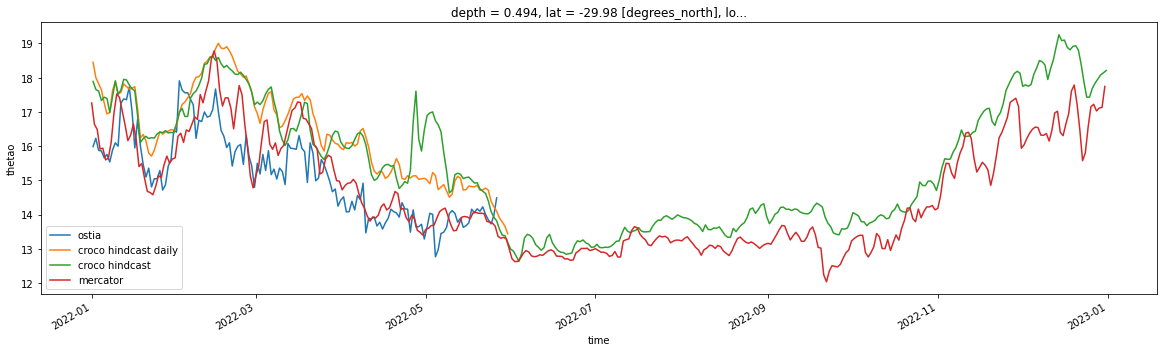

In [27]:
plt.figure(figsize=(20,5))
lat,lon = -30.0,-71.5
ostia.analysed_sst.sel(lat=lat, lon=lon, method='nearest').plot(label='ostia')
sst.temp.sel(lat=lat, lon=lon, method='nearest').plot(label='croco hindcast daily')
sst2.temp.sel(lat=lat, lon=lon, method='nearest').plot(label='croco hindcast')
sstmercator.thetao.sel(lat=lat, lon=lon, method='nearest').resample({'time':'d'}).mean().plot(label='mercator')
plt.legend()
